## **Dog Breed identification**

### **1. Download the dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!ls; tar -xvf images.tar

In [ ]:
!ls; pwd

drive  Images  images.tar  sample_data
/content


In [ ]:
!cd /content/Images;ls

In [ ]:
for dirname, _, filenames in os.walk('/content/Images'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [ ]:
def make_df():
  paths = []
  labels = []
  for dirname, _, filenames in os.walk('/content/Images'):
    for filename in filenames:
      if 'jpg' in filename:
        path = dirname + '/' + filename
        paths.append(path)
        start_point = path.find('/', 15)
        end_point = path.rfind('/')
        breed_extracted = path[start_point+1:end_point]
        breed = breed_extracted[breed_extracted.find('-')+1:]
        labels.append(breed)

  df = pd.DataFrame({'path':paths, 'label':labels})
  return df

In [ ]:
pd.set_option('display.max_colwidth', 200)
df = make_df()
df.shape

(20580, 2)

In [ ]:
df.head()

,path,label
0,/content/Images/n02094114-Norfolk_terrier/n02094114_1637.jpg,Norfolk_terrier
1,/content/Images/n02094114-Norfolk_terrier/n02094114_2428.jpg,Norfolk_terrier
2,/content/Images/n02094114-Norfolk_terrier/n02094114_754.jpg,Norfolk_terrier
3,/content/Images/n02094114-Norfolk_terrier/n02094114_4165.jpg,Norfolk_terrier
4,/content/Images/n02094114-Norfolk_terrier/n02094114_2706.jpg,Norfolk_terrier


In [ ]:
df['label'].value_counts()

Maltese_dog            252
Afghan_hound           239
Scottish_deerhound     232
Pomeranian             219
Samoyed                218
                      ... 
Irish_water_spaniel    150
clumber                150
Eskimo_dog             150
Pekinese               149
redbone                148
Name: label, Length: 120, dtype: int64

### **2. Visualize the data**

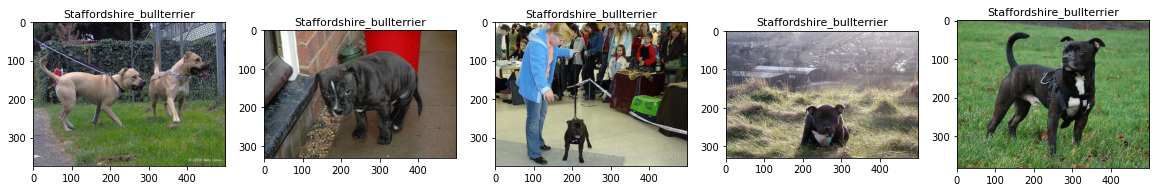

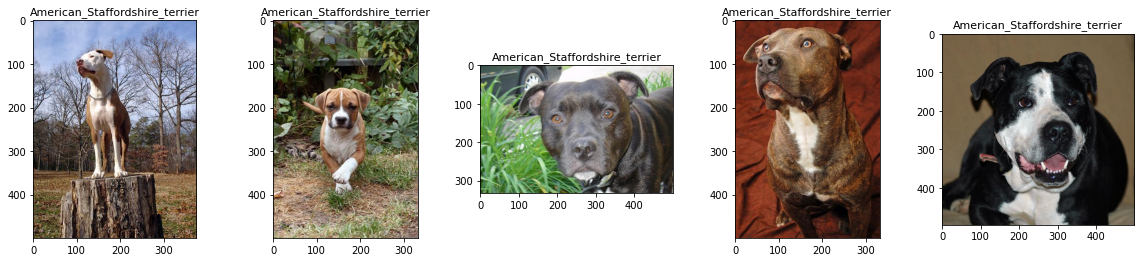

In [ ]:
import cv2

def show_images(image_path, ncols=5, title='input'):
  fig, axs = plt.subplots(figsize=(20, 4), nrows=1, ncols=ncols)
  for i in range(ncols):
    images = cv2.cvtColor(cv2.imread(image_path[i]), cv2.COLOR_BGR2RGB)
    axs[i].imshow(images)
    axs[i].set_title(title, fontsize=11)

image_path_01 = df[df['label'] == 'Staffordshire_bullterrier']['path'].iloc[:5].tolist()
image_path_02 = df[df['label'] == 'American_Staffordshire_terrier']['path'].iloc[:5].tolist()

show_images(image_path_01, ncols=5, title='Staffordshire_bullterrier')
show_images(image_path_02, ncols=5, title='American_Staffordshire_terrier')

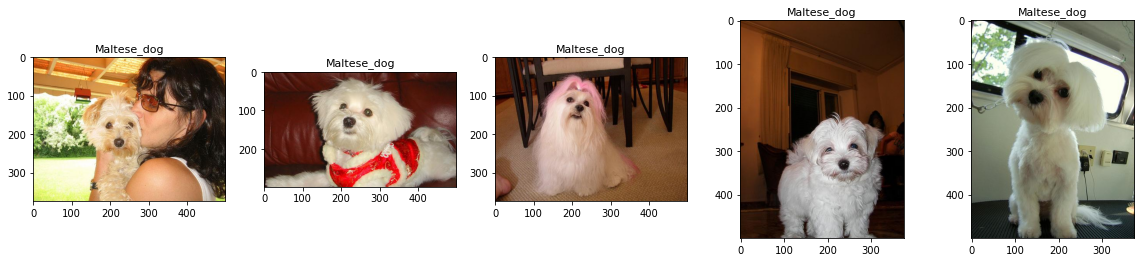

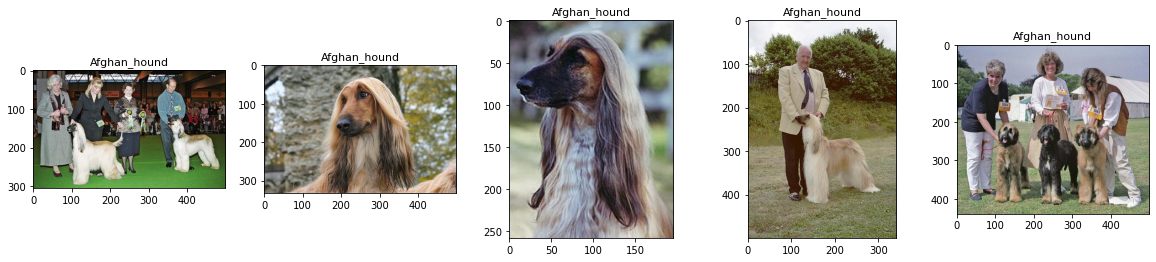

In [ ]:
breed_list = df['label'].value_counts().index.tolist()

for idx, breed in enumerate(breed_list):
  image_list_03 = df[df['label'] == breed]['path'].iloc[:5].tolist()
  show_images(image_list_03, ncols=5, title=breed)
  if idx == 1:
    break

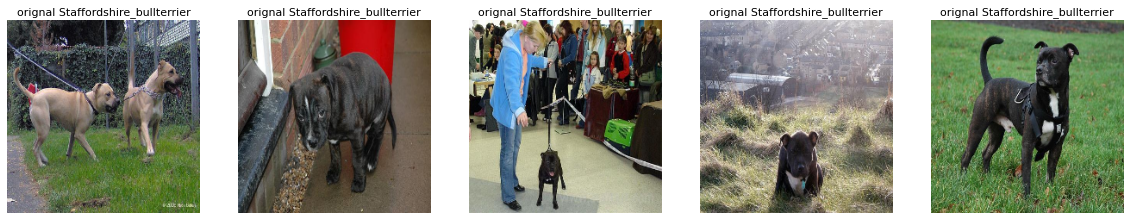

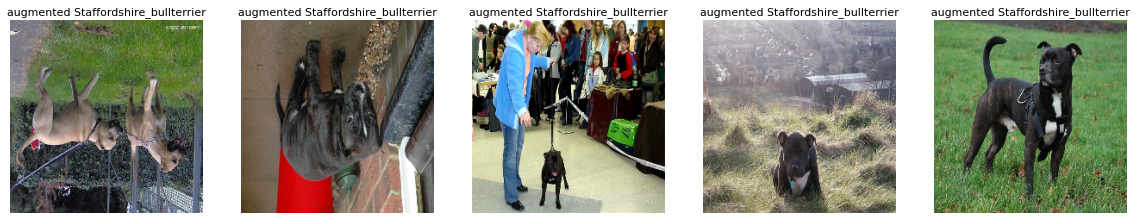

In [ ]:
import albumentations as A

augmentor_01 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5)])

def show_images_augmented(image_path, augmentor=None, ncols=5, title=None):
    fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path[i]), cv2.COLOR_BGR2RGB)
        if augmentor is not None:
          image = augmentor_01(image=image)['image']
        image = cv2.resize(image, (224, 224))
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(title, fontsize=11) 
        
image_path_04 = df[df['label']=='Staffordshire_bullterrier']['path'].iloc[:5].tolist()

show_images_augmented(image_path_04, augmentor=None, ncols=5, title='orignal Staffordshire_bullterrier')
show_images_augmented(image_path_04, augmentor=augmentor_01, ncols=5, title='augmented Staffordshire_bullterrier')

### **3. Preprocess the data+Sequence/Albumentation**

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
print(f'train_df : {train_df.shape}, test_df : {test_df.shape}')

train_df : (12348, 2), test_df : (8232, 2)


In [ ]:
train_path = train_df['path'].values
train_label = pd.get_dummies(train_df['label']).values

tr_path, val_path, tr_label, val_label = \
train_test_split(train_path, train_label, test_size=0.2, random_state=42)
print(f'tr_path : {tr_path.shape}, val_path : {val_path.shape}, tr_label : {tr_label.shape}, val_label : {val_label.shape}')

tr_path : (9878,), val_path : (2470,), tr_label : (9878, 120), val_label : (2470, 120)


In [ ]:
from tensorflow.keras.utils import Sequence
import albumentations as A

image_size = 224
batch_size = 64

class breed_dataset(Sequence):
  def __init__(self, image_path, label, image_size=image_size, batch_size=batch_size, augmentor=None, shuffle=False, pre_func=None):
    self.image_path = image_path
    self.label = label
    self.image_size = image_size
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.pre_func = pre_func

  def __len__(self):
    return int(np.ceil(len(self.label) / self.batch_size))

  def __getitem__(self, index):
    image_batch_size = self.image_path[index*self.batch_size:(index+1)*self.batch_size]
    if self.label is not None:
      label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
    
    image_batch = np.zeros((image_batch_size.shape[0], self.image_size, self.image_size, 3), dtype='float32')
    for image_index in range(image_batch_size.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_batch_size[image_index]), cv2.COLOR_BGR2RGB)
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
      image = cv2.resize(image, (image_size, image_size))
      if self.shuffle:
        self.on_epoch_end()
      else:
        pass
      if self.pre_func is not None:
        image = self.pre_func(image)
      image_batch[image_index] = image

    return image_batch, label_batch

  def on_epoch_end(self):
    if self.shuffle:
      self.image_path, self.label = sklearn.utils.shuffle(self.image_path, self.label)
    else:
      pass

augmentor_02 = A.Compose([A.HorizontalFlip(p=0.5)])

### **4. Build the model : Transfer learning(Xception)**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50V2, Xception, EfficientNetB0, EfficientNetB1
from tensorflow.keras.models import Model

def create_model(model_name='option'):
  input_tensor = Input(shape=(224, 224, 3))
  if model_name == 'ResNet50V2':
    base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'Xception':
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'EfficientNetB0':
    base_model = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'EfficientNetB1':
    base_model = EfficientNetB1(input_tensor=input_tensor, include_top=False, weights='imagenet')
  base_model_out = base_model.output
  
  x = GlobalAveragePooling2D()(base_model_out)
  x = Dense(1024, activation='relu')(x)
  output = Dense(120, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=output)
  model.summary()
  return model

###**5. Compile/Train the model**

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
  
def train_model(model_name, initial_lr=0.0001, augmentor=None, pre_func=None):
  tr_dataset = breed_dataset(tr_path, tr_label, image_size=image_size, batch_size=batch_size, augmentor=augmentor, shuffle=True, pre_func=pre_func)
  val_dataset = breed_dataset(val_path, val_label, image_size=image_size, batch_size=batch_size, augmentor=None, shuffle=False, pre_func=pre_func)

  model = create_model(model_name=model_name)
  model.compile(optimizer=Adam(initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
  
  cb_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
  cb_esp = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

  history = model.fit(tr_dataset, epochs=30, validation_data=val_dataset, callbacks=([cb_rlr, cb_esp]), verbose=1)
  return model, history

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

xception_model, xception_history = train_model(model_name='Xception', initial_lr=0.0001, augmentor=augmentor_02, pre_func=xcp_preprocess_input)

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

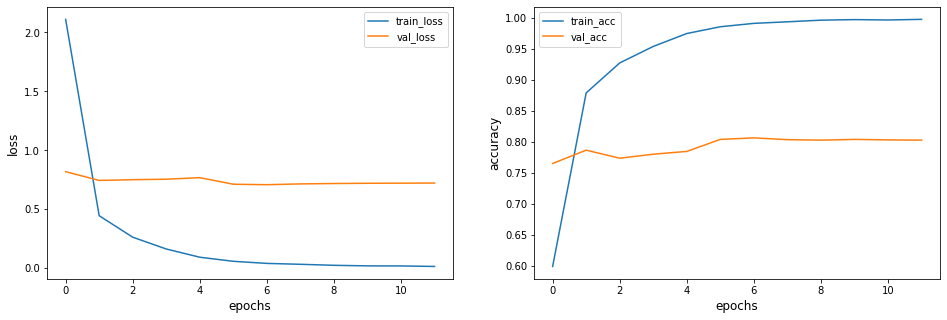

In [ ]:
def show_result(history):
  fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  axs[0].plot(history.history['loss'], label='train_loss')
  axs[0].plot(history.history['val_loss'], label='val_loss')
 
  axs[1].plot(history.history['accuracy'], label='train_acc')
  axs[1].plot(history.history['val_accuracy'], label='val_acc')

  axs[0].legend()
  axs[0].set_xlabel('epochs', fontsize=12)
  axs[0].set_ylabel('loss', fontsize=12)

  axs[1].legend()
  axs[1].set_xlabel('epochs', fontsize=12)
  axs[1].set_ylabel('accuracy', fontsize=12)
  plt.show()

show_result(xception_history)

### **6. Evaluate the model**

In [ ]:
test_path = test_df['path'].values
test_label = pd.get_dummies(test_df['label']).values

test_dataset = breed_dataset(test_path, test_label, image_size=image_size, 
                             batch_size=batch_size, augmentor=None, shuffle=False, pre_func=xcp_preprocess_input)

xception_model.evaluate(test_dataset)

129/129 [==============================] - 37s 283ms/step - loss: 0.6366 - accuracy: 0.8239


[0.6366329789161682, 0.8238581418991089]

### **7. Make predictions**

In [ ]:
result = xception_model.predict(test_dataset)

In [ ]:
test_df['test_class'] = np.argmax(test_label, axis=1)
test_df['predict_test_class'] = np.argmax(result, axis=1)
test_df

,path,label,test_class,predict_test_class
10848,/content/Images/n02111500-Great_Pyrenees/n02111500_8915.jpg,Great_Pyrenees,30,30
8499,/content/Images/n02110806-basenji/n02110806_3581.jpg,basenji,75,75
16201,/content/Images/n02096585-Boston_bull/n02096585_1992.jpg,Boston_bull,11,11
18589,/content/Images/n02108551-Tibetan_mastiff/n02108551_1689.jpg,Tibetan_mastiff,67,46
159,/content/Images/n02094114-Norfolk_terrier/n02094114_2394.jpg,Norfolk_terrier,47,47
...,...,...,...,...
3162,/content/Images/n02107683-Bernese_mountain_dog/n02107683_4782.jpg,Bernese_mountain_dog,7,7
1093,/content/Images/n02087046-toy_terrier/n02087046_2279.jpg,toy_terrier,116,101
3152,/content/Images/n02107683-Bernese_mountain_dog/n02107683_4885.jpg,Bernese_mountain_dog,7,7
3769,/content/Images/n02090721-Irish_wolfhound/n02090721_954.jpg,Irish_wolfhound,36,36


In [ ]:
test_df[test_df['test_class'] != test_df['predict_test_class']]

,path,label,test_class,predict_test_class
18589,/content/Images/n02108551-Tibetan_mastiff/n02108551_1689.jpg,Tibetan_mastiff,67,46
10181,/content/Images/n02096294-Australian_terrier/n02096294_6995.jpg,Australian_terrier,5,73
4337,/content/Images/n02085936-Maltese_dog/n02085936_9927.jpg,Maltese_dog,44,63
13875,/content/Images/n02112018-Pomeranian/n02112018_2782.jpg,Pomeranian,53,30
2634,/content/Images/n02098286-West_Highland_white_terrier/n02098286_260.jpg,West_Highland_white_terrier,72,59
...,...,...,...,...
4516,/content/Images/n02110185-Siberian_husky/n02110185_10360.jpg,Siberian_husky,64,24
2042,/content/Images/n02089867-Walker_hound/n02089867_142.jpg,Walker_hound,69,77
5776,/content/Images/n02109961-Eskimo_dog/n02109961_4451.jpg,Eskimo_dog,24,64
5485,/content/Images/n02088094-Afghan_hound/n02088094_7260.jpg,Afghan_hound,0,113


In [ ]:
test_df[test_df['test_class'] != test_df['predict_test_class']]['label'].value_counts()

Siberian_husky                    38
Eskimo_dog                        33
American_Staffordshire_terrier    32
miniature_poodle                  29
Lhasa                             28
                                  ..
English_springer                   3
Irish_water_spaniel                3
Mexican_hairless                   2
Leonberg                           2
Saint_Bernard                      1
Name: label, Length: 119, dtype: int64

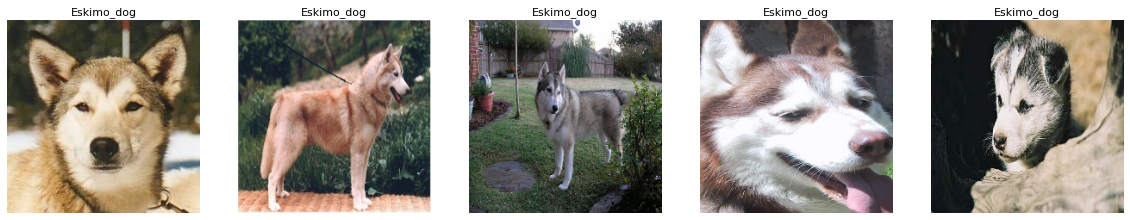

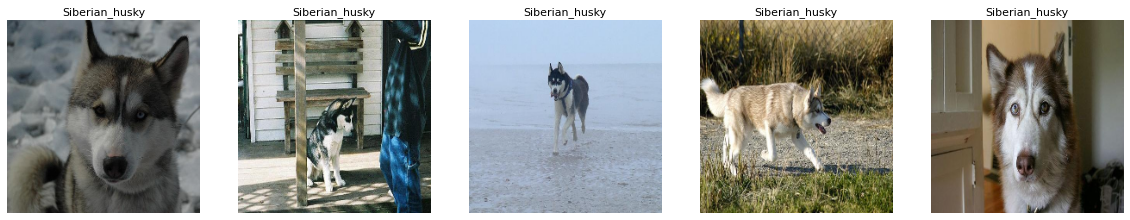

In [ ]:
image_path_05 = df[df['label']=='Eskimo_dog']['path'].iloc[:5].tolist()       
image_path_06 = df[df['label']=='Siberian_husky']['path'].iloc[:5].tolist()  
show_images_augmented(image_path_05, ncols=5, title='Eskimo_dog')
show_images_augmented(image_path_06, ncols=5, title='Siberian_husky')